---

#University of Stirling - Spring 2023

## CSCU9M6 - Natural Language Processing and Computer Vision (2022/3)

---

# Assignment Summary

In this activity, you are required to apply the knowledge acquired in this module through the design and development of a complete project for image classification in an application to be defined by yourself. For this, you will need to perform the following **mandatory** steps:

1. [Problem definition](#scrollTo=hglJVRRslqMn)
2. [GitHub repository](#scrollTo=ecxDhkV9qmUf)
3. [Dataset](#scrollTo=qEgFzxmWrGA9)
4. [Dataloader](#scrollTo=EDd6lLwlx4un)
5. [Proposed solution](#scrollTo=ScTrpUW8zOp4)
6. [Experimental tests and evaluations](#scrollTo=3RBW58of0ZDo)
7. [Quiz and Report](#scrollTo=ws14iV4Dp_vf)

**Deadlines** and other details can be seen on Canvas [\[link\]](https://canvas.stir.ac.uk/courses/12587/assignments/102373).

---

# 1. **Problem definition** 


In this assignment, you are required to apply the knowledge acquired in the module to solve a classification problem from images collected in the context of two different cities (A and B).
 - If the work is being carried out in pairs, **cities A and B must be the hometowns of each student**. In the case of individual work, city A must be your hometown and city B must be Stirling (or Edinburgh, if needed).
 - The standard recommendation is that the project focuses on classifying cars or trees image scenes, which are easier to identify and annotate. Other objects or phenomena can be adopted, but are subject to prior approval by the module instructor (Jefersson A. dos Santos). **You are not allowed to assemble datasets containing people. Other sensitive patterns, such as license plates, must be properly hidden.**
 - Don't panic! We are aware that acquiring images _in situ_ is an impediment for most students. The dataset can be assembled with images collected remotely or from public repositories. Just be careful with rights and permissions for using images found on the internet. Anyway, these factors must be taken into account for the problem definition.
 - While we encourage you to do interesting and engaging work, it shouldn't be too complex or time-consuming. Try to appropriately scale the time required for this step. Ask the instructors for advice, if necessary. **GA students:** you are encouraged to link the project with your work activities, but keep in mind you still need to construct two datasets (A and B). 

[top](#scrollTo=4i5afvUbhmGo)
 

---
# 2. **GitHub repository**

Give your project a name, create a private [GitHub repository](https://github.com/) with the name [Module Code] + [Project Name] and give access to the module instructors. Create a cover page with a description of your project. This empty notebook must be uploaded in the repository as well as the created dataset. The deadline to perform this task will be 10 days after the publication of this notebook. 
This notebook should be updated and committed to the repository according to the deadlines.
The repository's update history will be used as a criterion for monitoring and evaluating the work.
**Check the videos provided in the extra section on Canvas for more details on how to create your GitHub repository** [\[link\]](https://canvas.stir.ac.uk/courses/12587/pages/extra-session-cnn-hyperparameters-and-github).

[top](#scrollTo=4i5afvUbhmGo)

---
# 3. **Dataset creation**

You must collect a minimum of **200 positive samples** from the study objects for each city (A and B). 
Note that, depending on the task being solved, it will also be necessary to collect more samples - negative ones, for instance.

Your dataset can be assembled from one or more of the following ways:

  - *M1* - Pictures taken by yourself on site (street view from cities A and B), with attention to anonymization issues (if it is the case). It is not allowed to assemble datasets containing people. Other sensitive patterns, such as license plates, must be properly hidden.

  - *M2* - Aerial satellite/drone images obtained from GIS and remote sensing platforms or public repositories. Be careful with unusual file formats that may be challenging to manipulate using basic image processing libraries. We recommend keeping or converting the images to jpg or png.

  - *M3* - Pictures taken from other public available datasets. Remember you are not allowed to use datasets containing people or other sensitive patterns/objects.

  - *M4* - Images crawled from the internet as a whole (social networks, webpages, etc), with special attention to use and copyrights.

  - *M5* - Textual and metadata you may need in your project, with special attention to use and copyrights (as always!).

**Important:** If you collect the images on your own or from aerial imagery repositories, it will be necessary to keep the geographic coordinates. If you collect from specific websites, please retain the source links. This information should be placed in a .csv file and made available along with the final dataset.

[top](#scrollTo=4i5afvUbhmGo)

---

# 4. **Dataloader**

Here you are required to implement all the code related to pre-processing, cleaning, de-noising and preparing the input images and metadata according to the necessary data structures as input to your pattern recognition module. We recommend using [PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) or [Tensorflow (with Keras)](https://keras.io/getting_started/intro_to_keras_for_engineers/) as a base, but you are free to use any library or platform as long as it is well justified in the [final report](#scrollTo=ws14iV4Dp_vf).

[top](scrollTo=4i5afvUbhmGo)

In [1]:
#Mounting my google drive storage
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


Found 520 files belonging to 2 classes.
Using 416 files for training.
Found 520 files belonging to 2 classes.
Using 104 files for validation.
Found 490 files belonging to 2 classes.
Using 392 files for training.
Found 490 files belonging to 2 classes.
Using 98 files for validation.


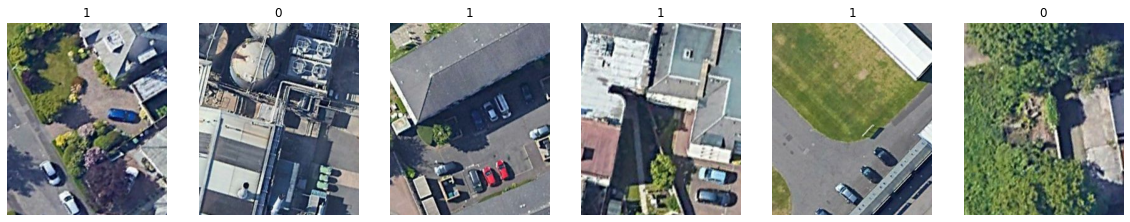

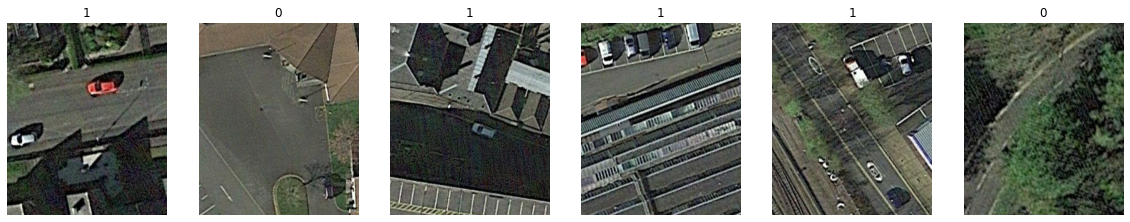

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

def dataloader(filepath, trainSize, testSize):
  #Training dataset 80%
  train_ds = tf.keras.utils.image_dataset_from_directory(
    filepath,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(308, 256),
    batch_size = trainSize
  )

  #Testing dataset 20%
  val_ds = tf.keras.utils.image_dataset_from_directory(
    filepath,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(308, 256),
    batch_size = testSize 
  )

  #Get classification names (0 no cars or 1 for cars)
  class_names = train_ds.class_names

  #Standardizing the data to minimise input
  normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

  #Plot sample of images from both datasets
  plt.figure(figsize=(20, 20))
  for images, labels in normalized_ds.take(1):
    for i in range(6):
      ax = plt.subplot(1, 6, i + 1)
      plt.imshow(images[i])
      plt.title(class_names[labels[i]])
      plt.axis("off")

#Load Edinburgh dataset
dataloader("/content/drive/MyDrive/M6/Edinburgh", 416, 104)
#Load Stirling dataset
dataloader("/content/drive/MyDrive/M6/Stirling", 392, 98)



---

# 5. **Proposed solution** 

This is where you should implement most of your code for your solution. Write the routines for training and predicting the models and any necessary intermediate steps. Post-processing functions must also be implemented here.

  - Use good programming practices, modularizing and adequately commenting on your code. Code quality will be considered in the final assessment.

  - You can use pre-trained models as backbones or any code available on the web as a basis, but they must be correctly credited and referenced both in this notebook and in the final report. Cite the source link repository and explicitly cite the authors of it.
If you changed existing code, make it clear what the changes were.
Make it clear where your own code starts and where it ends. Note that the originality percentage of the code will be considered in the evaluation, so use external codes wisely and sparingly. **Missconduct alert:** remember that there are many tools that compare existing source code and that it is relatively easy to identify authorship. So, be careful and fair by always properly thanking the authors if you use external code.

[top](#scrollTo=4i5afvUbhmGo)

In [ ]:
# Write your proposed solution code here. Create more code cells if you find it necessary





---

# 6. **Experimental tests and evaluations** 


Here you must implement your code for training, testing and evaluating your solution. For this, the following code blocks (*E1*, *E2*, and *E3*) are mandatory:

  - *E1* - Training the models. Implement code to call the dataloaders implemented for training your models.  Make routines to test different parameters of your models. Plot graphs that illustrate how parameters impact model training. Compare. Train and select a model for each city (A and B) and justify. You should use half (50%) of the samples from each dataset for training and leave the other half for testing (50%). 

[top](#scrollTo=4i5afvUbhmGo)

In [ ]:
# Write your codes for E1 here. Create more code cells if needed





  - *E2* - Testing the models in the dataset. You must implement code routines to test the predictive ability of your models using half of each dataset intended for testing. **The model trained in city A must be tested in city A. The model trained in city B must be tested in city B.** Use the evaluation metrics (accuracy, F1-score, AUC, etc) that are most appropriate for your problem. Plot graphs that illustrate the results obtained for each city (A and B). Plot visual examples of correctly (true positive) and incorrectly (false positive) classified samples. 

[top](#scrollTo=4i5afvUbhmGo)


In [ ]:
# Write your codes for E2 here. Create more code cells if needed





  - *E3* - Testing the models crossing datasets. Here you must do exactly the same as in *E2*, but now training in one city and testing in the other. **The model trained in city A must be tested in city B. The model trained in city B must be tested in city A.** Use the same metrics and plot the same types of graphs so that results are comparable.

[top](scrollTo=4i5afvUbhmGo)

In [ ]:
# Write your codes for E3 here. Create more code cells if needed





---

# 7. **Quiz and Report**

Answer the assessment quiz that will be made available on Canvas one week before the final deadline. Make a 2-page report using the [IEEE template](https://www.overleaf.com/read/rdqwshtvyjdn) with a maximum of 1000 words. Latex is recommended, but you can deliver the report in MS Word if you prefer. Your report should contain five sections: introduction, description of the proposed solution with justifications, results (here you can include the same graphs and pictures generated in this jupyter notebook), discussion of the results, and conclusion. Properly cite references to articles, tutorials, and sources used. A pdf version of your report should be made available in the project's github repository under the name "[project name] + _final_report.pdf".


[top](#scrollTo=4i5afvUbhmGo)